# Simulations with WindGym Environments

This notebook provides a comprehensive guide to running simulations in WindGym, focusing on the core environment classes: `WindFarmEnv` and `FarmEval`. We'll explore their differences, intended use cases, and how to interact with them for both single-agent and multi-agent scenarios.

## 1. Core WindGym Environments: `WindFarmEnv` vs. `FarmEval`

WindGym offers two primary environment classes for different simulation needs:

1.  **`WindFarmEnv`**: The base, general-purpose environment.
2.  **`FarmEval`**: A specialized subclass of `WindFarmEnv` designed specifically for evaluation and fixed-condition simulations.

Understanding their relationship and distinctions is crucial for effective use of WindGym.

### `WindFarmEnv`: The Flexible Base Environment

`WindFarmEnv` is your go-to environment for general-purpose wind farm simulations. It's designed to be flexible, supporting various configurations and dynamic wind conditions, making it suitable for:

* **Reinforcement Learning Training**: Agents can learn to adapt to changing wind conditions over long episodes.
* **Stochastic Wind Sampling**: It can integrate with PyWake `Site` objects (`sample_site` parameter) to sample realistic wind speeds and directions based on wind resource distributions (e.g., Weibull for speed, frequency for direction). If `sample_site` is not provided, it samples uniformly from defined min/max ranges.
* **Dynamic Changes**: While this version primarily uses steady wind within an episode, `WindFarmEnv`'s architecture allows for future extensions that could introduce wind changes mid-episode.
* **Multi-Agent Foundation**: It serves as the base for the `WindFarmEnvMulti` environment (discussed later) for decentralized control problems.

### `FarmEval`: The Evaluation-Focused Environment

`FarmEval` is a direct subclass of `WindFarmEnv` (`class FarmEval(WindFarmEnv):`). It inherits all capabilities of `WindFarmEnv` but **overrides key behaviors** to facilitate precise and reproducible evaluations under specific, controlled conditions. Its main features include:

* **Fixed Wind Conditions**: `FarmEval` allows you to *directly set* the wind speed (`ws`), wind direction (`wd`), and turbulence intensity (`ti`) via `set_wind_vals()` *before* calling `reset()`. This overrides any stochastic sampling, ensuring the environment always starts with the exact specified wind conditions.
* **Evaluation Loop Compatibility**: It is specifically used by the `AgentEval` class (and its `eval_single_fast` function) for running standardized benchmarks, as demonstrated later in this notebook.
* **Non-Terminating Episodes**: By default, `FarmEval` episodes are "infinite" (or very long, set by `time_max = 9999999`) unless `finite_episode=True` is explicitly set. This ensures that evaluation runs for a consistent duration without premature termination.
* **Baseline Comparison**: It often enables the `Baseline_comp=True` flag by default or is configured to always run a parallel baseline simulation for direct comparison of agent performance.

### Key Differences Summary

| Feature                  | `WindFarmEnv`                                        | `FarmEval`                                                 |
| :----------------------- | :--------------------------------------------------- | :--------------------------------------------------------- |
| **Base Class** | `gymnasium.Env`                                      | `WindFarmEnv`                                              |
| **Primary Use** | RL Training, General Simulation (stochastic wind)    | Fixed-condition Evaluation, Benchmarking                   |
| **Wind Conditions** | Randomly sampled (from ranges or `sample_site`)      | Explicitly set via `set_wind_vals()` (overrides sampling) |
| **Episode Length** | Defined by `n_passthrough`, can terminate/truncate   | Effectively 'infinite' by default (`time_max` overwritten) |
| **`reset()` behavior** | Samples new wind unless overridden                   | Uses explicitly set wind conditions                        |
| **Stochasticity** | High (wind sampling, turbulence generation)          | Controlled (fixed wind for evaluation)                     |
| **Parameter Setting** | Parameters set during initialization (`__init__`)    | Parameters can be explicitly set/overridden via methods    |

---

Now, let's start by setting up the necessary imports and a `config.yaml` file that both environments will use.

### Initial Setup: Imports and Configuration File

We'll need common Python libraries and specific WindGym components. We'll also define a `config.yaml` file, which specifies various environment parameters like observation details, reward functions, and action methods. Ensure this `config.yaml` is saved in the same directory as this notebook.

In [12]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import os
import yaml
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Import WindGym environment classes
from WindGym.Wind_Farm_Env import WindFarmEnv
from WindGym.FarmEval import FarmEval
from WindGym.AgentEval import eval_single_fast
from WindGym.Agents import PyWakeAgent, RandomAgent
from WindGym.WindEnvMulti import WindFarmEnvMulti

# Import a default turbine model from PyWake
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site # Hornsrev1Site for stochastic wind example

#### `config.yaml` Content

Create a file named `config.yaml` in the same directory as this notebook with the following content. This file defines the detailed behavior of the WindGym environments.

In [13]:
# This cell is for display purposes only. 
# You should create a physical file named 'config.yaml' with this content.
config_yaml_content = """
yaw_init: "Zeros"
noise: "None"
BaseController: "Local"
ActionMethod: "wind"
Track_power: False
act_pen:
  action_penalty: 0.0
  action_penalty_type: "Change"
power_def:
  Power_scaling: 1000000000.0
  Power_avg: 50
  Power_reward: "Baseline"
mes_level:
  turb_ws: True
  turb_wd: True
  turb_TI: False
  turb_power: True
  farm_ws: True
  farm_wd: True
  farm_TI: False
  farm_power: True
  ti_sample_count: 30
ws_mes:
  ws_current: False
  ws_rolling_mean: True
  ws_history_N: 1
  ws_history_length: 10
  ws_window_length: 10
wd_mes:
  wd_current: False
  wd_rolling_mean: True
  wd_history_N: 1
  wd_history_length: 10
  wd_window_length: 10
yaw_mes:
  yaw_current: False
  yaw_rolling_mean: True
  yaw_history_N: 2
  yaw_history_length: 30
  yaw_window_length: 1
power_mes:
  power_current: False
  power_rolling_mean: True
  power_history_N: 1
  power_history_length: 10
  power_window_length: 10
farm:
  yaw_min: -45
  yaw_max: 45
wind:
  ws_min: 8.0
  ws_max: 12.0
  TI_min: 0.07
  TI_max: 0.15
  wd_min: 260.0
  wd_max: 280.0
"""

# Write the content to config.yaml if it doesn't exist
yaml_path = 'config.yaml'
if not os.path.exists(yaml_path):
    with open(yaml_path, 'w') as f:
        f.write(config_yaml_content)
    print(f"Created '{yaml_path}' with default content.")
else:
    print(f"'{yaml_path}' already exists. Using existing file.")

'config.yaml' already exists. Using existing file.


## 2. Basic `WindFarmEnv` Usage: Training Environment

Let's demonstrate how to initialize and interact with the base `WindFarmEnv`. This environment is typically used for training Reinforcement Learning agents, where wind conditions might vary from episode to episode.

In [14]:
# Define turbine positions (e.g., two turbines placed along the x-axis)
x_pos_base = np.array([0, 500])  # Meters
y_pos_base = np.array([0, 0])    # Meters

# Initialize the WindFarmEnv
env = WindFarmEnv(
    turbine=V80(),              # The wind turbine model to use
    x_pos=x_pos_base,           # X-coordinates of the turbines
    y_pos=y_pos_base,           # Y-coordinates of the turbines
    n_passthrough=5,            # Simulate for 5 "flow passthroughs" to define episode length
    dt_sim=1,                   # Internal simulation timestep in seconds (e.g., DWM solver step)
    dt_env=5,                   # Environment timestep in seconds (how often the agent acts)
                                # dt_env must be a multiple of dt_sim
    yaw_step_sim=1,             # Maximum 1 degree yaw change per dt_sim
    yaml_path=yaml_path,        # Path to the YAML configuration file
    Baseline_comp=True,         # Enable a parallel baseline farm for comparison
    render_mode=None,           # Set to 'human' for visualization, 'None' for headless operation
    seed=42                     # Random seed for reproducibility
)

print(f"Initialized WindFarmEnv: Observation Space {env.observation_space}, Action Space {env.action_space}")

Initialized WindFarmEnv: Observation Space Box(-1.0, 1.0, (13,), float32), Action Space Box(-1.0, 1.0, (2,), float32)


### Interacting with `WindFarmEnv`: `reset()` and `step()`

The standard Gymnasium API (`reset()` and `step()`) is used for interaction.

#### Resetting the Environment

`env.reset()` initializes a new episode. In `WindFarmEnv`, this involves sampling new global wind conditions (speed, direction, turbulence intensity) within the ranges defined in `config.yaml`, setting up a turbulence field, initializing turbine yaw angles, and running a "burn-in" period to stabilize the flow.

In [15]:
# Reset the environment to start a new episode
observation, info = env.reset()

print("\n--- Initial State of WindFarmEnv ---")
print("Initial Observation (scaled between -1 and 1):\n", observation)
print("\nInitial Info Dictionary (contains raw values and metadata):")
for key, value in info.items():
    if isinstance(value, np.ndarray):
        print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
    else:
        print(f"  {key}: {value}")

print(f"\nInitial Wind Conditions for this episode: WS={info['Wind speed Global']:.2f} m/s, WD={info['Wind direction Global']:.2f} deg, TI={info['Turbulence intensity']:.2f}")


--- Initial State of WindFarmEnv ---
Initial Observation (scaled between -1 and 1):
 [-0.42823637  0.60337114  0.          0.         -0.13359714 -0.50257933
  0.43192136  0.          0.         -0.32335526 -0.46540785  0.51764727
 -0.22847617]

Initial Info Dictionary (contains raw values and metadata):
  yaw angles agent: shape=(2,), dtype=float64
  yaw angles measured: shape=(4,), dtype=float32
  Wind speed Global: 8.376709391550598
  Wind speed at turbines: shape=(2,), dtype=float64
  Wind speed at turbines measured: shape=(2,), dtype=float32
  Wind speed at farm measured: shape=(1,), dtype=float32
  Wind direction Global: 275.22279403980707
  Wind direction at turbines: shape=(2,), dtype=float64
  Wind direction at turbines measured: shape=(2,), dtype=float32
  Wind direction at farm measured: shape=(1,), dtype=float32
  Turbulence intensity: 0.14804978813094047
  Power agent: 2085915.779813882
  Power pr turbine agent: shape=(2,), dtype=float64
  Turbine x positions: shape=(2,),

#### Taking Steps (`env.step()`)

In each `step()`, your agent provides an `action` (a NumPy array scaled between -1 and 1), and the environment returns the `next_observation`, `reward`, `terminated` flag, `truncated` flag, and an updated `info` dictionary.

In [16]:
num_steps = 5 # Number of environment steps to simulate

print(f"\nRunning {num_steps} steps in WindFarmEnv with random actions...")
for i in range(num_steps):
    # Check if the episode has ended
    if info.get('terminated', False) or info.get('truncated', False):
        print(f"Episode ended at step {i}.\n")
        break

    # Sample a random action from the environment's action space
    action = env.action_space.sample()

    # Take a step in the environment with the sampled action
    observation, reward, terminated, truncated, info = env.step(action)

    print(f"\n--- Step {i+1} ---")
    print(f"Action (raw): {action}")
    print(f"Reward: {reward:.4f}")
    print(f"Farm Power (Agent): {info['Power agent'] / 1e6:.2f} MW")
    if 'Power baseline' in info: # Baseline power is only available if Baseline_comp is True
        print(f"Farm Power (Baseline): {info['Power baseline'] / 1e6:.2f} MW")
    print(f"Current Yaw Angles (Agent): {np.round(info['yaw angles agent'], 2)}")
    print(f"Time: {info['time_array'][-1]:.2f} s")
    
print("\nClosing WindFarmEnv...")
env.close()
print("WindFarmEnv closed.")


Running 5 steps in WindFarmEnv with random actions...

--- Step 1 ---
Action (raw): [ 0.6677968 -0.2510572]
Reward: -45960.5606
Farm Power (Agent): 1.81 MW
Farm Power (Baseline): 1.82 MW
Current Yaw Angles (Agent): [ 5. -5.]
Time: 273.00 s

--- Step 2 ---
Action (raw): [0.8449401  0.04216858]
Reward: -354896.7954
Farm Power (Agent): 1.46 MW
Farm Power (Baseline): 1.51 MW
Current Yaw Angles (Agent): [10.  0.]
Time: 278.00 s

--- Step 3 ---
Action (raw): [-0.2520533  -0.27232793]
Reward: -559915.8743
Farm Power (Agent): 1.68 MW
Farm Power (Baseline): 1.69 MW
Current Yaw Angles (Agent): [ 5. -5.]
Time: 283.00 s

--- Step 4 ---
Action (raw): [-0.2370901  -0.19239934]
Reward: -707186.6477
Farm Power (Agent): 1.91 MW
Farm Power (Baseline): 1.93 MW
Current Yaw Angles (Agent): [ 0.   -8.66]
Time: 288.00 s

--- Step 5 ---
Action (raw): [-0.32090938  0.66990954]
Reward: -816561.9354
Farm Power (Agent): 1.99 MW
Farm Power (Baseline): 2.00 MW
Current Yaw Angles (Agent): [-5.   -3.66]
Time: 293.00

## 3. Running Simulations with `FarmEval`: Evaluation and Pre-built Agents

`FarmEval` is ideal for reproducible evaluations under fixed wind conditions, which is crucial for benchmarking and comparing different agents. Here, we'll use it to evaluate a `PyWakeAgent`.


--- Running simulation with PyWakeAgent using eval_single_fast ---


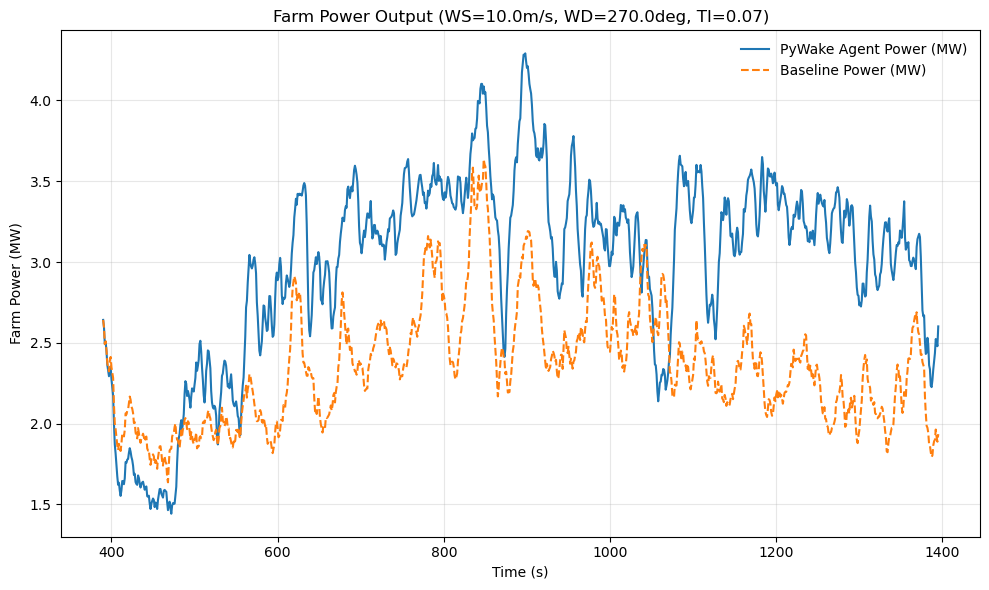


Closing FarmEval environment...
FarmEval environment closed.


In [17]:
# Define turbine positions for a small farm for evaluation (e.g., three turbines in a row)
x_pos_eval = np.array([0, 600, 1200]) # meters
y_pos_eval = np.array([0, 0, 0])      # meters

# Initialize the FarmEval environment
eval_env = FarmEval(
    turbine=V80(),
    x_pos=x_pos_eval,
    y_pos=y_pos_eval,
    n_passthrough=2,     # important
    dt_sim=1,
    dt_env=5,
    yaw_step_sim=1,
    yaml_path=yaml_path,
    Baseline_comp=True,     # Essential for comparing agent to a baseline
    render_mode=None,       # Typically headless for evaluations to speed up
    seed=42,
    # For fixed wind condition evaluation, ensure sample_site is None.
    # The wind conditions are set directly via eval_env.set_wind_vals().
    sample_site=None
)

# Set specific, fixed wind conditions for this evaluation run BEFORE resetting
eval_env.set_wind_vals(ws=10.0, ti=0.07, wd=270.0)

# Initialize the PyWakeAgent
# The PyWakeAgent calculates optimal yaw angles based on the current wind conditions
pywake_agent = PyWakeAgent(
    x_pos=x_pos_eval,
    y_pos=y_pos_eval,
    turbine=V80(),
    env=eval_env # Pass the environment object to the agent for context
)

print("\n--- Running simulation with PyWakeAgent using eval_single_fast ---")
# eval_single_fast runs a full episode with the specified agent and returns an xarray Dataset
# t_sim specifies the total simulation time in seconds
eval_results = eval_single_fast(
    env=eval_env,
    model=pywake_agent,
    ws=10.0,
    ti=0.07,
    wd=270.0,
    t_sim=1000,             # Simulate for 1000 seconds
    save_figs=False,        # Set to True to generate frame-by-frame plots (can be very slow)
    debug=False,
    deterministic=True,     # Use deterministic policy for the agent
    name="PyWake_3Turbines_Test"
)

#print("\nPyWakeAgent Evaluation Results (first few data points):")
# Select a single wind speed, direction, and TI for plotting, assuming eval_results has these dimensions
selected_data = eval_results.sel(ws=10.0, wd=270.0, TI=0.07, method='nearest')
#print(selected_data['powerF_a'].head())

# Access the underlying data for plotting, and use .squeeze() to remove singleton dimensions
agent_power = selected_data['powerF_a'].squeeze().values 
baseline_power = selected_data['powerF_b'].squeeze().values 
time_steps = selected_data['time'].values

# Plot the farm power output over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, agent_power / 1e6, label='PyWake Agent Power (MW)')
plt.plot(time_steps, baseline_power / 1e6, label='Baseline Power (MW)', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Farm Power (MW)')
plt.title(f'Farm Power Output (WS={selected_data.ws.item()}m/s, WD={selected_data.wd.item()}deg, TI={selected_data.TI.item()})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\nClosing FarmEval environment...")
eval_env.close() # Important: close the evaluation environment to release resources
print("FarmEval environment closed.")

## 4. Multi-Agent Simulations (`WindFarmEnvMulti`)

WindGym also supports multi-agent environments, where each turbine can be controlled by an independent agent. This is achieved using `WindFarmEnvMulti`, which wraps `WindFarmEnv` to conform to the [PettingZoo Parallel API](https://pettingzoo.farama.org/api/parallel/).

In this setup:
* Each turbine is considered a separate 'agent'.
* `reset()` and `step()` methods return dictionaries where keys are agent IDs (e.g., `'turbine_0'`, `'turbine_1'`).
* Actions provided to `step()` must also be a dictionary with agent IDs as keys.

In [18]:
# # Define turbine positions for a multi-agent farm (e.g., three turbines)
# x_pos_multi = np.array([0, 500, 1000]) # 3 turbines for multi-agent setup
# y_pos_multi = np.array([0, 0, 0])

# # Initialize the multi-agent environment
# multi_env = WindFarmEnvMulti(
#     turbine=V80(),
#     n_passthrough=5,
#     dt_sim=1,
#     dt_env=5,
#     yaw_step=1,             # Note: This is now `yaw_step` in multi-agent env,
#                             # representing the max yaw change per env step for all turbines
#     yaml_path=yaml_path,
#     Baseline_comp=False,    # Baseline comparison is typically handled externally for multi-agent setups
#     render_mode=None,
#     seed=42
# )

# # Optional: Test PettingZoo API compliance (uncomment to run)
# # This will run a series of checks on your environment to ensure it adheres to the PettingZoo API.
# # from pettingzoo.test import parallel_api_test # You'd need to install pettingzoo to run this
# # print("\n--- Running PettingZoo API test for WindFarmEnvMulti ---")
# # parallel_api_test(multi_env, num_cycles=100)
# # print("PettingZoo API test passed!")

# # Reset the multi-agent environment to start a new episode
# observations, infos = multi_env.reset()

# # Initialize an agent for each possible turbine in the environment
# # The `agents` dictionary maps each agent_id (e.g., 'turbine_0') to its corresponding agent object.
# agents = {agent_id: RandomAgent(env=multi_env) for agent_id in multi_env.possible_agents}
# print(f"\nInitialized {len(agents)} agents: {list(agents.keys())}")

# num_steps_multi = 5
# print(f"\nRunning {num_steps_multi} multi-agent steps...")

# for i in range(num_steps_multi):
#     actions = {}
#     # Each active agent determines its action
#     for agent_id in multi_env.agents: # Iterate over active agents (those not terminated/truncated)
#         # Agents take actions based on their individual observation.
#         # For simplicity, RandomAgent doesn't use the observation for its decision.
#         action, _ = agents[agent_id].predict(observations[agent_id])
#         actions[agent_id] = action

#     # Step the multi-agent environment with actions from all active agents
#     observations, rewards, terminations, truncations, infos = multi_env.step(actions)

#     print(f"\n--- Multi-Agent Step {i+1} ---")
#     print(f"Actions: {actions}")
#     print(f"Rewards: {rewards}")
#     print(f"Terminations: {terminations}")
#     print(f"Truncations: {truncations}")
#     # Example of accessing info for a specific agent (uncomment to see output)
#     # if 'turbine_0' in infos:
#     #     print(f"Agent 0 Yaw: {infos['turbine_0']['yaw angles agent']:.2f} deg")

#     # Check if all agents have terminated or truncated
#     if all(terminations.values()) or all(truncations.values()):
#         print(f"Multi-agent episode ended at step {i+1}.\n")
#         break

# print("\nClosing Multi-Agent environment...")
# multi_env.close()
# print("Multi-Agent environment closed.")